In [1]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.7.2     ✔ stringr 1.2.0
✔ readr   1.1.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘ggridges’ was built under R version 3.4.4”Warning message:
“package ‘ggthemes’ was built under R version 3.4.4”
Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths



In [2]:
agg_data_path = '/Users/Krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/'
setwd(agg_data_path)

In [3]:
# linux_data_path <- '/home/krista/Documents/gitRepositories/volatileValues/simple_rt_experiment_probabilityC/data/'
# setwd(linux_data_path)

In [4]:
# (files <- dir(path = linux_data_path, pattern = "^[0-9](.*)(_trialset[0-9].csv)$"))

In [5]:
# raw_df <- files %>%
#   map(read_csv,col_types = cols()) %>%                  
#   reduce(rbind) 

In [6]:
# (ID = map(files, substr, start=1, stop=4))
# raw_df$ID = as.numeric(ID)

In [7]:
# condition = map(files, substr, start=10, stop=10)
# raw_df$condition <- as.numeric(condition)
# raw_df$condition <- recode(raw_df$condition, '0' = 'lc', '1' = 'hc', '2'='hv','3'='lv')
# head(raw_df)

In [8]:
clean_df <- read_csv('cleaned_probC_data_test.csv',col_types = cols())
raw_df <- read_csv('raw_probC_data_test.csv',col_types = cols())

colnames(clean_df)[1] <- c('trial')
colnames(raw_df)[1] <- c('trial')

head(clean_df); head(raw_df)

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Missing column names filled in: 'X1' [1]”

trial,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
0,1,1,1,1,600,0.5257449,2.060731,0.5456106,0,0,112,770,hc
1,0,0,1,0,599,0.2968972,1.812463,0.5248838,0,1,111,770,hc
2,1,0,0,0,598,0.2102492,1.496023,0.3045535,0,0,111,770,hc
3,1,1,1,3,600,0.2763972,1.937237,0.6750797,0,1,112,770,hc
4,0,1,0,3,602,0.2870722,1.813193,0.5382493,0,0,112,770,hc
5,1,1,1,2,603,0.2484522,1.718456,0.4735218,0,0,112,770,hc


trial,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
0,1,1,1,1,600,0.5257449,2.060731,0.5456106,0,0,112,770,hc
1,0,0,1,0,599,0.2968972,1.812463,0.5248838,0,1,111,770,hc
2,1,0,0,0,598,0.2102492,1.496023,0.3045535,0,0,111,770,hc
3,1,1,1,3,600,0.2763972,1.937237,0.6750797,0,1,112,770,hc
4,0,1,0,3,602,0.2870722,1.813193,0.5382493,0,0,112,770,hc
5,1,1,1,2,603,0.2484522,1.718456,0.4735218,0,0,112,770,hc


In [9]:
(n_subjects = length(unique(raw_df$ID)))
(n_conditions = length(unique(raw_df$condition)))
n_clean_trials = 600
(expected_rows = n_subjects*n_conditions*n_clean_trials)

[1] 11

[1] 4

[1] 26400

In [10]:
fast_slow_trial_freq <- raw_df %>% 
    group_by(ID, condition) %>%  summarize(n_fast_trials = sum(cp_with_slow_fast == -2), 
n_slow_trials = sum(cp_with_slow_fast == -1))

(unique_conds_per_s <- raw_df %>% 
    group_by(ID) %>% summarise(unique_conds_per_s=n_distinct(condition)) )

ID,unique_conds_per_s
761,4
762,4
763,4
764,4
765,4
766,4
767,2
768,2
769,2
770,2


In [11]:
(group_acc <- clean_df %>% 
group_by(condition) %>%  summarize(mean_acc = mean(accuracy))
)
(group_rt <- clean_df %>% 
group_by(condition) %>% summarize(mu_rt=mean(rt)))

condition,mean_acc
hc,0.5314815
hv,0.5550000
lc,0.6526190
lv,0.5846296


condition,mu_rt
hc,0.3353002
hv,0.3452122
lc,0.3254590
lv,0.3302457


In [12]:
(total_n_trials <- n_clean_trials + fast_slow_trial_freq$n_fast_trials + fast_slow_trial_freq$n_slow_trials
)
round(fast_slow_trial_freq$n_fast_trials/total_n_trials,4)
round(fast_slow_trial_freq$n_slow_trials/total_n_trials,4)

[1] 601 600 600 601 608 604 603 601 604 623 609 612 614 614 604 608 603 601 605
[20] 606 606 609 604 604 608 605 721 635 608 608 602 601 602 603

[1] 0.0000 0.0000 0.0000 0.0017 0.0000 0.0033 0.0017 0.0000 0.0066 0.0177
[11] 0.0115 0.0180 0.0147 0.0179 0.0066 0.0066 0.0033 0.0000 0.0066 0.0033
[21] 0.0066 0.0131 0.0050 0.0066 0.0082 0.0017 0.0624 0.0409 0.0099 0.0099
[31] 0.0033 0.0000 0.0017 0.0000

[1] 0.0017 0.0000 0.0000 0.0000 0.0132 0.0033 0.0033 0.0017 0.0000 0.0193
[11] 0.0033 0.0016 0.0081 0.0049 0.0000 0.0066 0.0017 0.0017 0.0017 0.0066
[21] 0.0033 0.0016 0.0017 0.0000 0.0049 0.0066 0.1054 0.0142 0.0033 0.0033
[31] 0.0000 0.0017 0.0017 0.0050

In [13]:
head(raw_df)
(n_subjects = length(unique(raw_df$ID))
)
(n_conditions = length(unique(raw_df$condition))
)# clean_df <- subset(raw_df, cp_with_slow_fast == 0 | cp_with_slow_fast == 1)
# # clean_df$trial <- rep(seq(1,600),n_subjects*n_conditions)
# # dim(clean_df)


trial,choice,accuracy,solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,high_val_cue,ID,condition
0,1,1,1,1,600,0.5257449,2.060731,0.5456106,0,0,112,770,hc
1,0,0,1,0,599,0.2968972,1.812463,0.5248838,0,1,111,770,hc
2,1,0,0,0,598,0.2102492,1.496023,0.3045535,0,0,111,770,hc
3,1,1,1,3,600,0.2763972,1.937237,0.6750797,0,1,112,770,hc
4,0,1,0,3,602,0.2870722,1.813193,0.5382493,0,0,112,770,hc
5,1,1,1,2,603,0.2484522,1.718456,0.4735218,0,0,112,770,hc


[1] 11

[1] 4

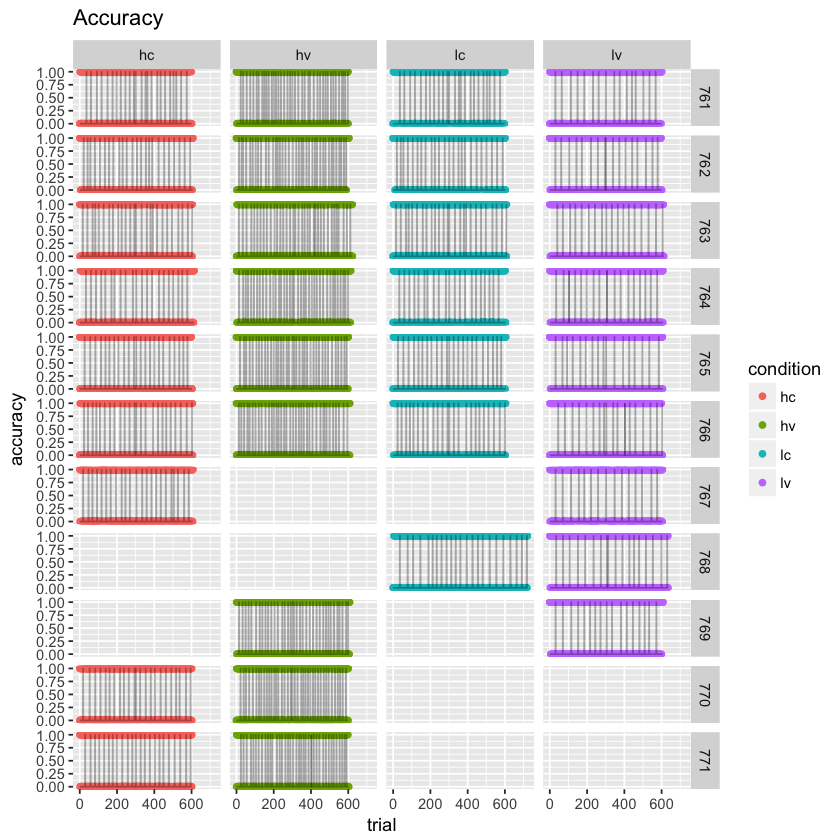

In [14]:
ggplot(clean_df, aes(trial, accuracy, color=condition)) +
    geom_point() +  geom_line(data=clean_df, aes(trial, cp_with_slow_fast), alpha=0.3,col='black') + facet_grid( ID ~ condition) + ggtitle('Accuracy') 

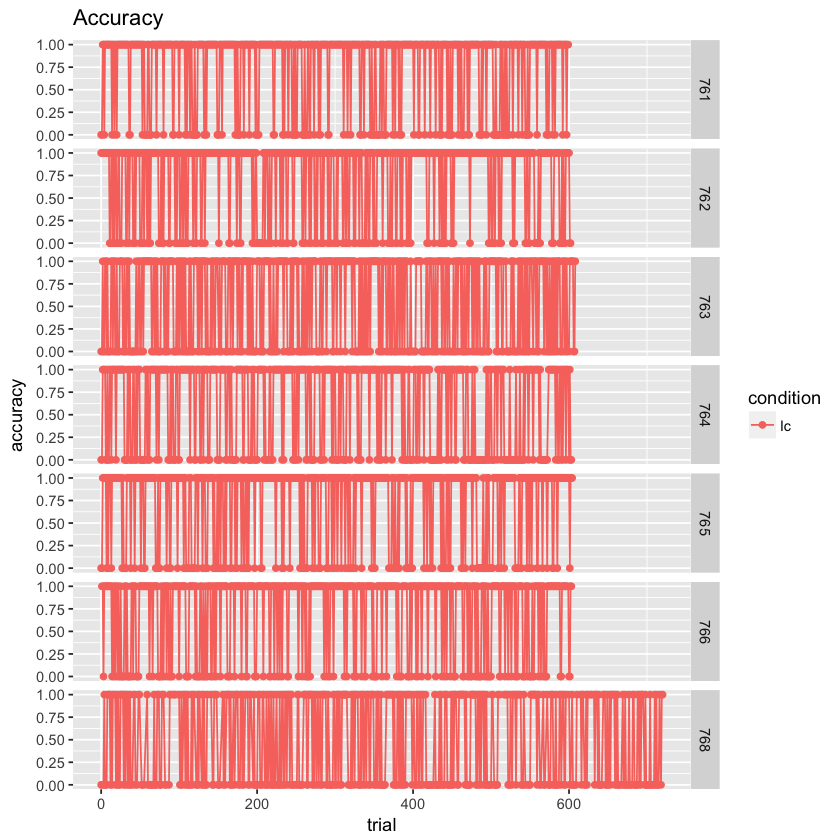

In [15]:
ggplot(subset(clean_df, condition=='lc'), aes(trial, accuracy, color=condition)) +
    geom_point() + geom_line() + facet_grid( ID~.) + ggtitle('Accuracy')

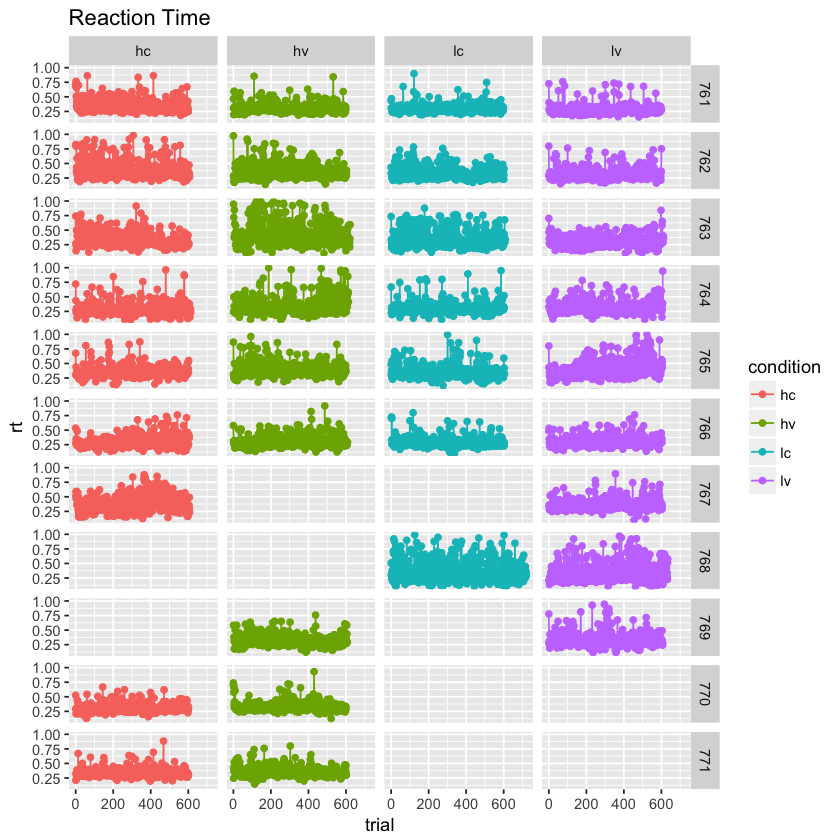

In [16]:
ggplot(clean_df, aes(trial, rt, color=condition)) +
    geom_point() + geom_line() + facet_grid(ID ~ condition) + ggtitle('Reaction Time')

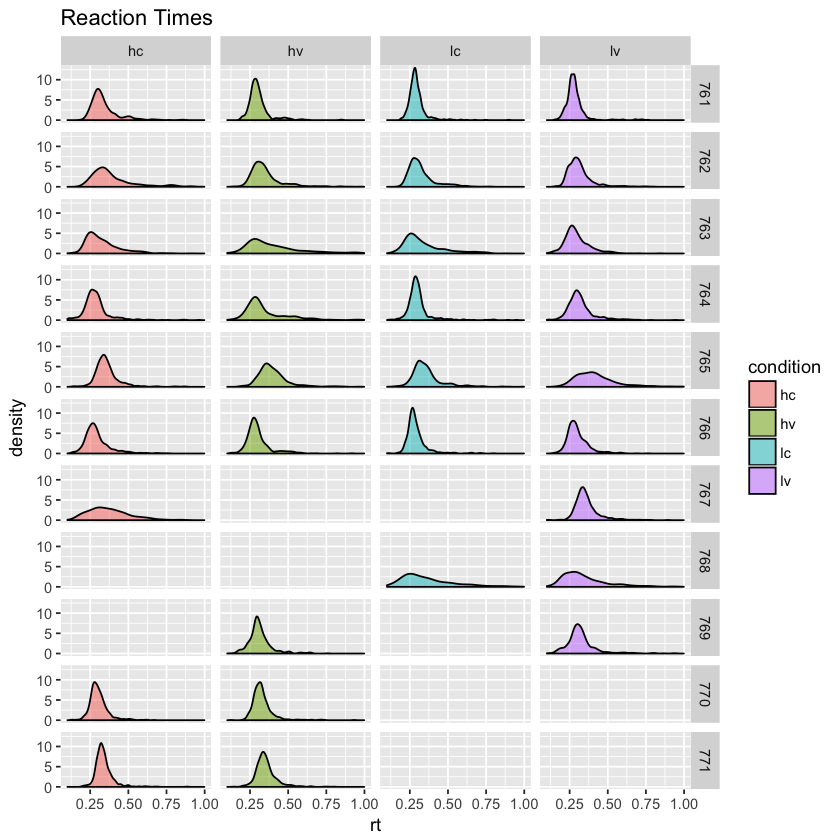

In [17]:
ggplot(clean_df, aes(rt, fill=condition)) +
geom_density(alpha=0.5) + facet_grid(ID ~ condition) + ggtitle('Reaction Times')

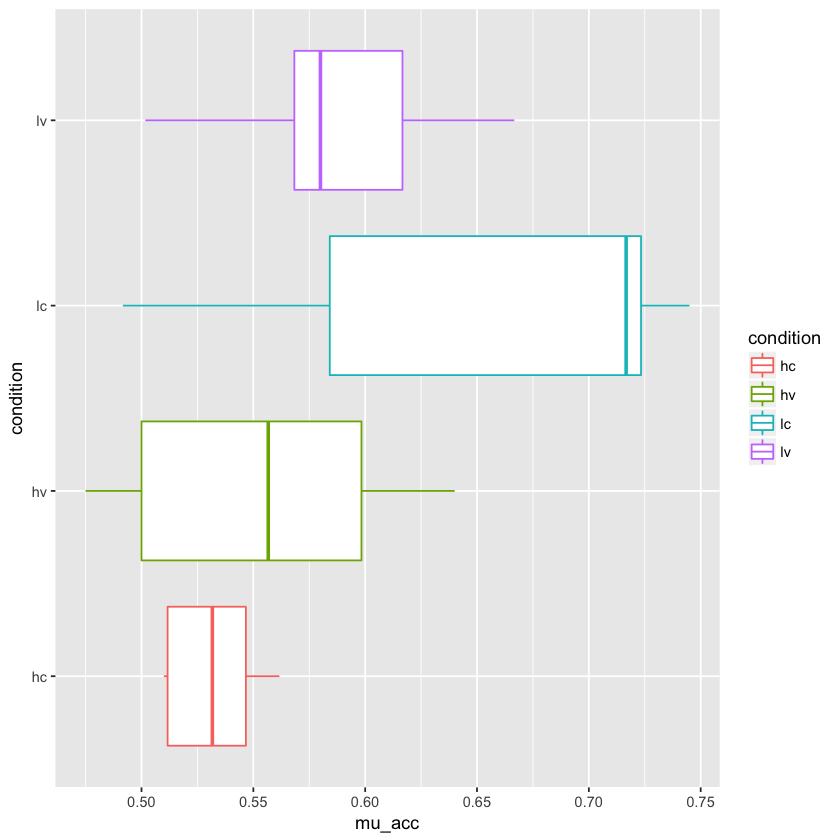

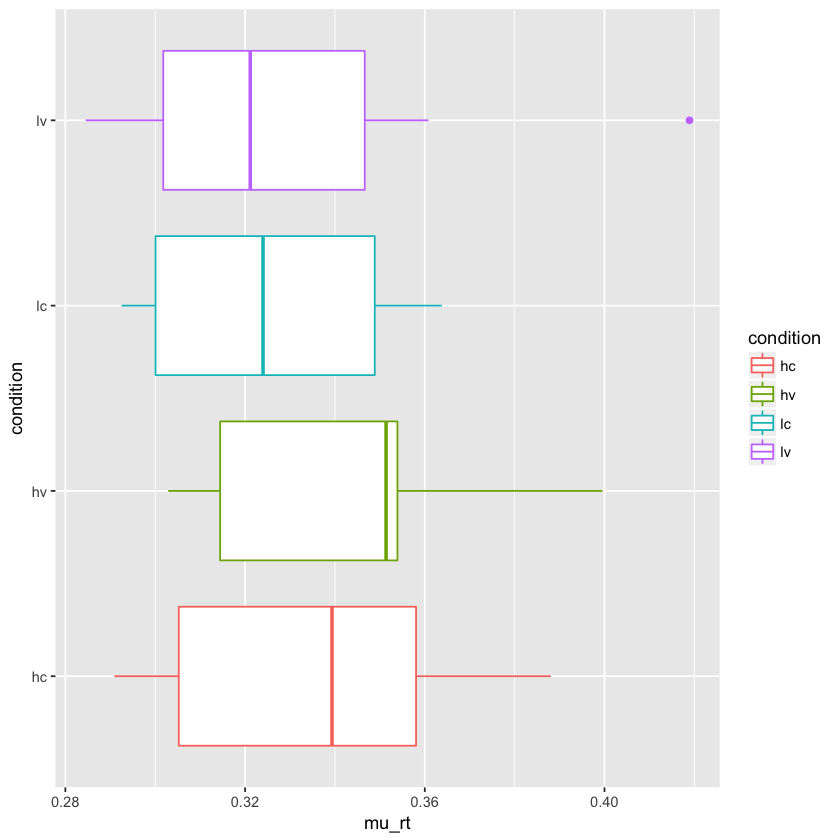

In [18]:
acc_stats <- clean_df %>% 
    group_by(ID, condition) %>% summarize(mu_acc=mean(accuracy))

rt_stats <- clean_df %>% 
    group_by(ID, condition) %>% summarize(mu_rt=mean(rt))

# ggplot(acc_stats, aes(mu_acc, ID)) +
#     geom_point(aes(fill=condition)) + coord_flip()

ggplot(acc_stats, aes(x=condition, y=mu_acc)) +
    geom_boxplot(aes(color=condition)) + coord_flip()

ggplot(rt_stats, aes(x=condition, y=mu_rt)) +
    geom_boxplot(aes(color=condition)) + coord_flip()

Picking joint bandwidth of 0.0115


Saving 7 x 7 in image
Picking joint bandwidth of 0.0115


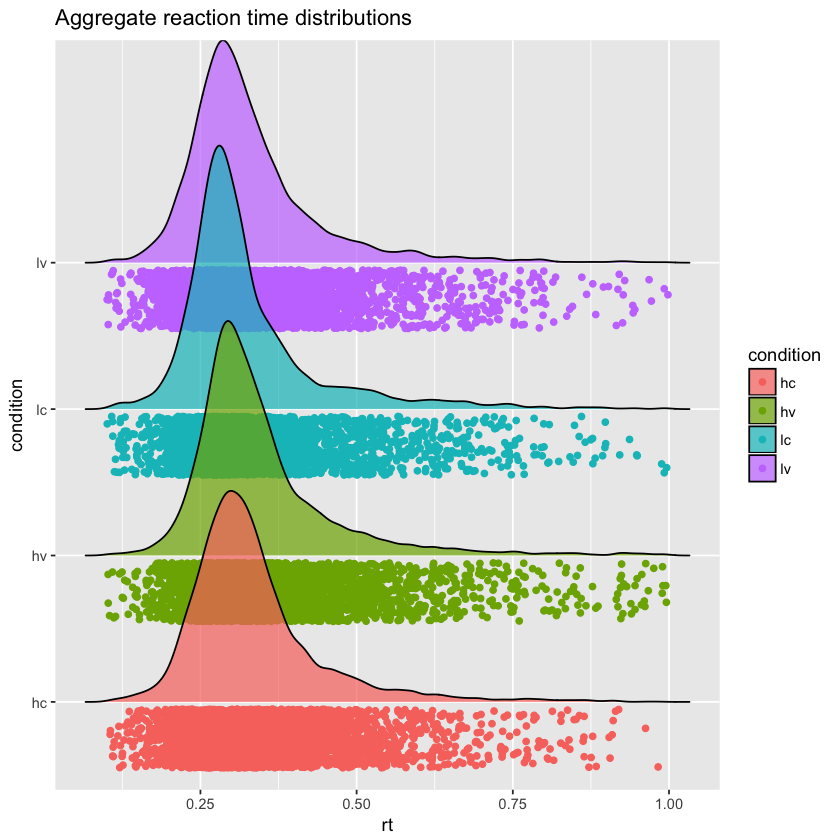

In [19]:
ggplot(clean_df, aes(rt,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) + ggtitle('Aggregate reaction time distributions ')

ggsave('condition_rt_dist.pdf')

In [20]:
# ggplot(clean_df, aes(accuracy,condition, fill=condition)) +
#   geom_density_ridges(jittered_points = TRUE, position = "raincloud",
#                       alpha = 0.7, aes(point_color = condition, point_fill = condition)) + facet_grid(ID ~.) + ggtitle('Subject-level accuracy distributions ')

Picking joint bandwidth of 0.0803


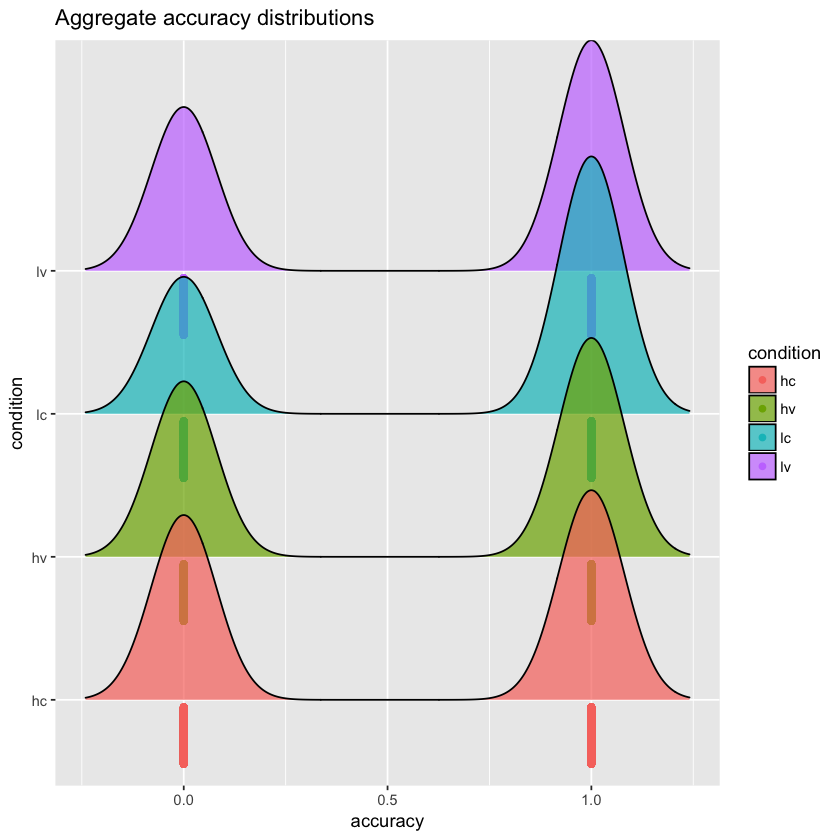

In [21]:
ggplot(clean_df, aes(accuracy,condition, fill=condition)) +
  geom_density_ridges(jittered_points = TRUE, position = "raincloud",
                      alpha = 0.7, aes(point_color = condition, point_fill = condition)) +  ggtitle('Aggregate accuracy distributions ')

In [22]:
#step 1: find the indices that correspond to the changepoint 
cp_idx <- which(clean_df$cp_with_slow_fast == 1)
#get trial before cp 
start_idx <- cp_idx - 1 
#add e. length  
end_idx <- cp_idx + 9

#construct intervals according to the start and end idx 
intervals <- mapply(seq, start_idx, end_idx)
conditions <- data.frame(condition=clean_df$condition[start_idx])
dim(conditions)

conditions_vec <- rep(conditions$condition, each=11)
rt_vec_slice <- clean_df$rt[intervals]
acc_vec_slice <- clean_df$accuracy[intervals]
# new_df = data.frame(t=conditions_vec)
# tail(new_df)

[1] 876   1

In [23]:
#check intervals
start_idx[3]
end_idx[3]
intervals[,3]
#next, construct new df with these vals. 

#interval columns are cps
#rows are trials

[1] 83

[1] 93

[1] 83 84 85 86 87 88 89 90 91 92 93

In [24]:
sliced_df <- melt(intervals)
colnames(sliced_df) <- c('epoch_trial', 'interval_number', 'trial')
head(sliced_df)
sliced_df$interval_number <- NULL 
str(sliced_df)


sliced_df$conditions <- conditions_vec
sliced_df$rt <- rt_vec_slice
sliced_df$acc <- acc_vec_slice

dim(sliced_df)
head(sliced_df)

epoch_trial,interval_number,trial
1,1,18
2,1,19
3,1,20
4,1,21
5,1,22
6,1,23


'data.frame':	9636 obs. of  2 variables:
 $ epoch_trial: int  1 2 3 4 5 6 7 8 9 10 ...
 $ trial      : int  18 19 20 21 22 23 24 25 26 27 ...


[1] 9636    5

epoch_trial,trial,conditions,rt,acc
1,18,hc,0.2199450,1
2,19,hc,0.2498889,0
3,20,hc,0.2342730,0
4,21,hc,0.3707180,0
5,22,hc,0.2110851,1
6,23,hc,0.3111939,0


In [25]:
lc <- sliced_df %>%
          filter(conditions =='lc')  

hc <- sliced_df %>%
          filter(conditions =='hc')  

lv <- sliced_df %>%
          filter(conditions =='lv')  
hv <- sliced_df %>%
          filter(conditions =='hv')  


lc_rt_vec = c(1:nrow(intervals))
hc_rt_vec = c(1:nrow(intervals))
hv_rt_vec = c(1:nrow(intervals))
lv_rt_vec = c(1:nrow(intervals))


lc_acc_vec = c(1:nrow(intervals))
hc_acc_vec = c(1:nrow(intervals))
hv_acc_vec = c(1:nrow(intervals))
lv_acc_vec = c(1:nrow(intervals))

for (idx in 1:nrow(intervals)){
lc_rt_vec[idx] <- mean(lc[lc$epoch_trial == idx, 'rt'], na.rm = TRUE)  
hc_rt_vec[idx] <- mean(hc[hc$epoch_trial == idx, 'rt'],na.rm = TRUE)   
hv_rt_vec[idx] <- mean(hv[hv$epoch_trial == idx, 'rt'],na.rm = TRUE)   
lv_rt_vec[idx] <- mean(lv[lv$epoch_trial == idx, 'rt'],na.rm = TRUE)  
    
lc_acc_vec[idx] <- mean(lc[lc$epoch_trial == idx, 'acc'],na.rm = TRUE)  
hc_acc_vec[idx] <- mean(hc[hc$epoch_trial == idx, 'acc'],na.rm = TRUE)   
hv_acc_vec[idx] <- mean(hv[hv$epoch_trial == idx, 'acc'],na.rm = TRUE)   
lv_acc_vec[idx] <- mean(lv[lv$epoch_trial == idx, 'acc'],na.rm = TRUE)  
}

acc_df <- data.frame(lc_acc_vec, hc_acc_vec,hv_acc_vec, lv_acc_vec)
rt_df <- data.frame(lc_rt_vec, hc_rt_vec,hv_rt_vec, lv_rt_vec)

In [26]:
gg_df_acc <- stack(acc_df)
gg_df_acc$ind <- sub("^(hc).*", "hc", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(lc).*", "lc", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(hv).*", "hv", gg_df_acc$ind)
gg_df_acc$ind <- sub("^(lv).*", "lv", gg_df_acc$ind)
colnames(gg_df_acc) <- c('accuracy', 'condition')


In [27]:
gg_df_rt <- stack(rt_df)
gg_df_rt$ind <- sub("^(hc).*", "hc", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(lc).*", "lc", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(hv).*", "hv", gg_df_rt$ind)
gg_df_rt$ind <- sub("^(lv).*", "lv", gg_df_rt$ind)
colnames(gg_df_rt) <- c('rt', 'condition')

In [28]:
gg_df <- cbind(gg_df_acc, gg_df_rt)
gg_df$trial <- rep(seq(1,11),4)
head(gg_df,12)

accuracy,condition,rt,condition,trial
0.6606061,lc,0.3266753,lc,1
0.3575758,lc,0.3397839,lc,2
0.4181818,lc,0.3213051,lc,3
0.5636364,lc,0.3263324,lc,4
0.6545455,lc,0.3276825,lc,5
0.6727273,lc,0.3238248,lc,6
0.6484848,lc,0.3203610,lc,7
0.6303030,lc,0.3311050,lc,8
0.7515152,lc,0.3270512,lc,9
0.7393939,lc,0.3330240,lc,10


In [29]:
conflict_rt_plt <- ggplot(subset(gg_df, condition=='hc'| condition=='lc'), aes(x=trial,y=rt, color=condition)) + geom_point() + geom_line()+ ylim(0.25,0.45) +  geom_vline(xintercept=2)
conflict_acc_plt <- ggplot(subset(gg_df, condition=='hc'| condition=='lc'), aes(x=trial,y=accuracy, color=condition)) + geom_point() + geom_line()+ ylim(0,1) +  geom_vline(xintercept=2) + geom_hline(yintercept = 0.65, color='red', alpha=0.5) + geom_hline(yintercept = 0.85, color='blue', alpha=0.5)

In [30]:
vol_rt_plt <- ggplot(subset(gg_df, condition=='hv'| condition=='lv'), aes(x=trial,y=rt, color=condition)) + geom_point() + geom_line()+ ylim(0.25,0.45) +  geom_vline(xintercept=2)
vol_acc_plt <- ggplot(subset(gg_df, condition=='hv'| condition=='lv'), aes(x=trial,y=accuracy, color=condition)) + geom_point() + geom_line()+ ylim(0,1) +  geom_vline(xintercept=2) + geom_hline(yintercept = 0.75, color='gray')

## Conflict time series 

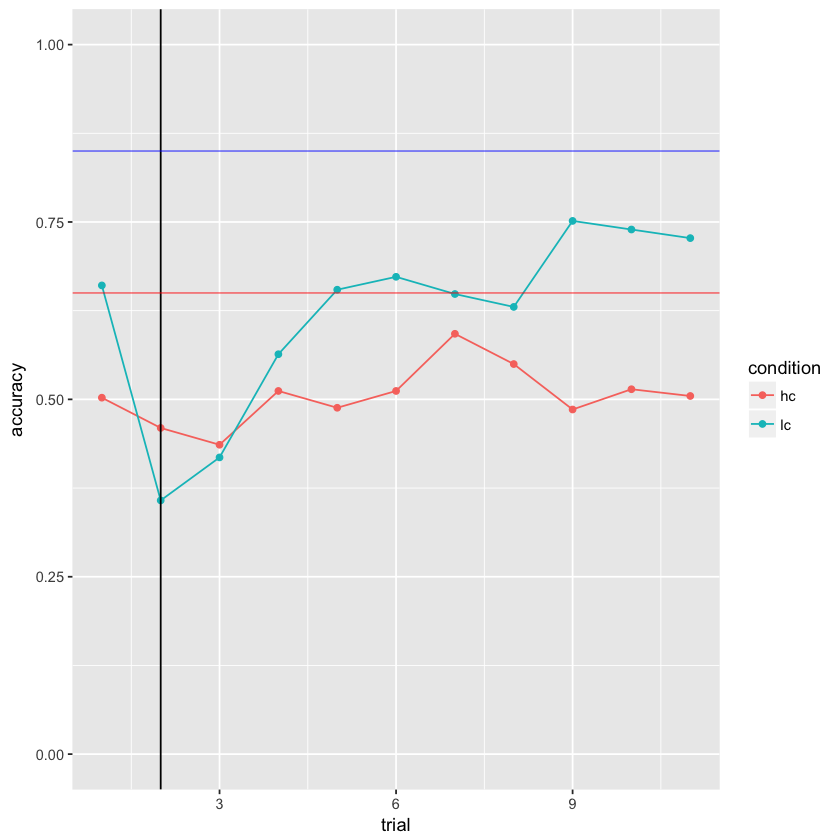

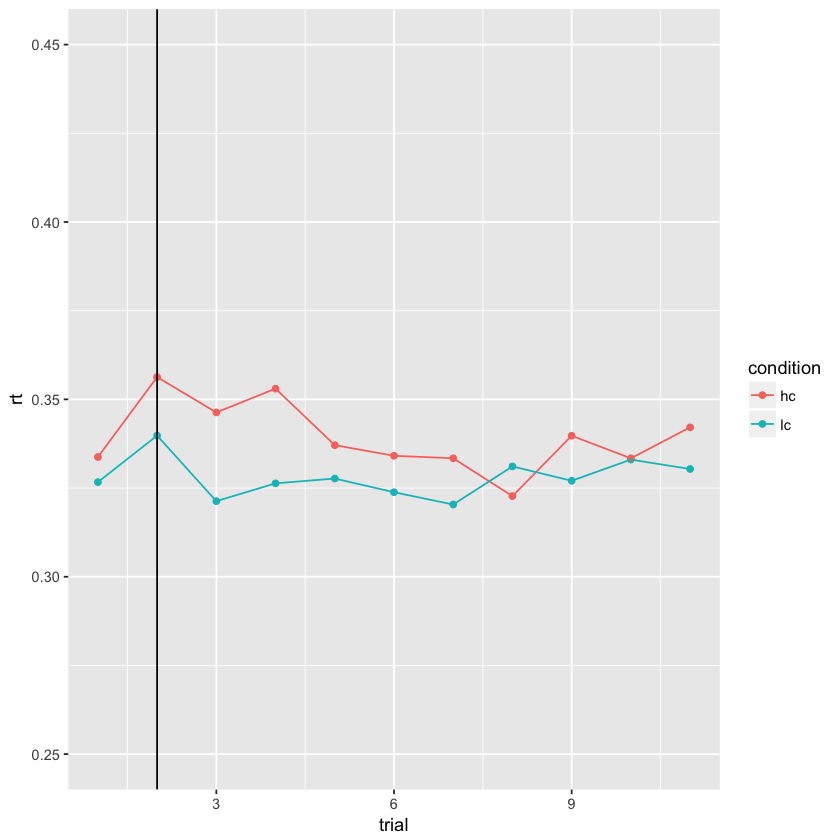

In [31]:
 conflict_acc_plt;conflict_rt_plt

## Volatility time series

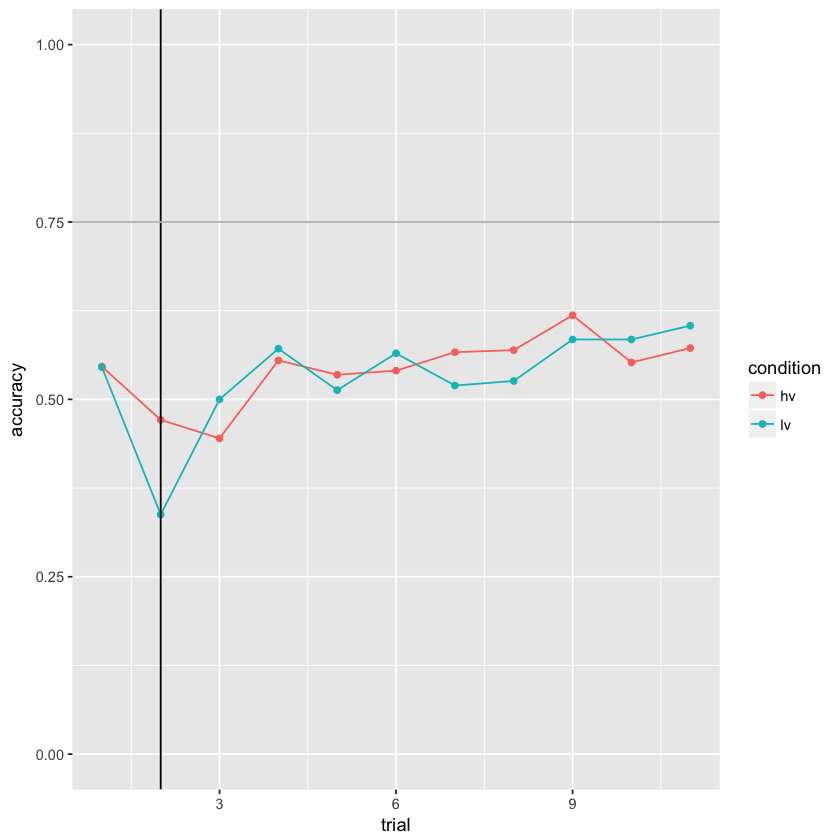

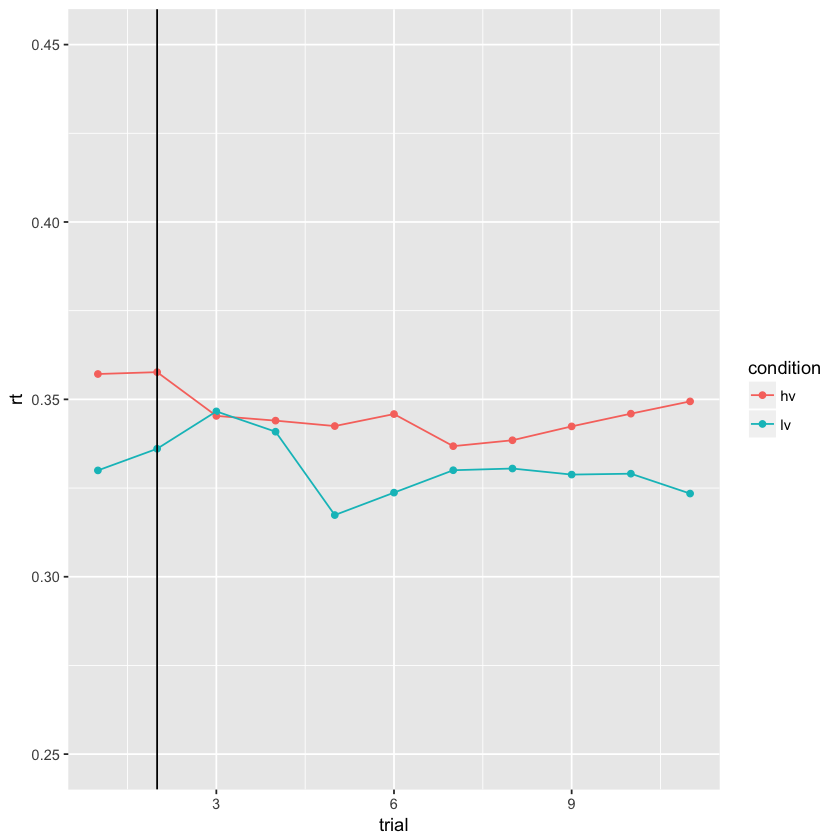

In [32]:
vol_acc_plt;vol_rt_plt

## Bootstrapped distributions of point estimates for behavior (mu accuracy, rt) 
### Note that this is currently over all trials. Need to bootstrap the average for each time point in the series that I'm plotting for nonparametric CIs.

In [41]:
setwd('/Users/Krista/Documents/R/functions')
source("bootstrap.R")

In [42]:
# would have been elegant but doesn't work as is
# condition_rt.boot <- sparse_df %>%  
#     group_by(condition)  %>% select(rt) %>% map(boot.mean)

In [43]:
hc_rt.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='hc'), 'rt']))
lc_rt.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='lc'), 'rt']))

hv_rt.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='hv'), 'rt']))
lv_rt.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='lv'), 'rt']))

In [45]:
hc_acc.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='hc'), 'accuracy']))
lc_acc.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='lc'), 'accuracy']))

hv_acc.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='hv'), 'accuracy']))
lv_acc.boot <- boot.mean(unlist(clean_df[which(clean_df$condition=='lv'), 'accuracy']))

In [46]:
hc_rt.boot$interval; lc_rt.boot$interval
hc_acc.boot$interval; lc_acc.boot$interval

[1] 0.3323524 0.3382480

[1] 0.3219589 0.3289591

[1] 0.5180822 0.5448807

[1] 0.6378888 0.6673493

In [47]:
hv_rt.boot$interval; lv_rt.boot$interval
hv_acc.boot$interval; lv_acc.boot$interval

[1] 0.3421868 0.3482376

[1] 0.3273118 0.3331797

[1] 0.5408442 0.5691558

[1] 0.5705617 0.5986976

In [48]:
#want to overlay bootstrapped distributions for counter conditions 
conflict_rt.boot <- data.frame(stack(c(hc_rt_boot = hc_rt.boot$boot.statistics, lc_rt_boot=lc_rt.boot$boot.statistics)))
colnames(conflict_rt.boot) = c('bootstrapped_rt', 'condition')
conflict_rt.boot$condition <- sub("^(hc).*", "hc", conflict_rt.boot$condition)
conflict_rt.boot$condition <- sub("^(lc).*", "lc", conflict_rt.boot$condition)

In [49]:
conflict_acc.boot <- data.frame(stack(c(hc_acc_boot = hc_acc.boot$boot.statistics, lc_acc_boot=lc_acc.boot$boot.statistics)))
colnames(conflict_acc.boot) = c('bootstrapped_acc', 'condition')
conflict_acc.boot$condition <- sub("^(hc).*", "hc", conflict_acc.boot$condition)
conflict_acc.boot$condition <- sub("^(lc).*", "lc", conflict_acc.boot$condition)

In [50]:
#volatility bootstrapping 
vol_rt.boot <- data.frame(stack(c(hv_rt_boot = hv_rt.boot$boot.statistics, lv_rt_boot=lv_rt.boot$boot.statistics)))
colnames(vol_rt.boot) = c('bootstrapped_rt', 'condition')
vol_rt.boot$condition <- sub("^(hv).*", "hv", vol_rt.boot$condition)
vol_rt.boot$condition <- sub("^(lv).*", "lv", vol_rt.boot$condition)

In [51]:
vol_acc.boot <- data.frame(stack(c(hv_acc_boot = hv_acc.boot$boot.statistics, lv_acc_boot=lv_acc.boot$boot.statistics)))
colnames(vol_acc.boot) = c('bootstrapped_acc', 'condition')
vol_acc.boot$condition <- sub("^(hv).*", "hv", vol_acc.boot$condition)
vol_acc.boot$condition <- sub("^(lv).*", "lv", vol_acc.boot$condition)

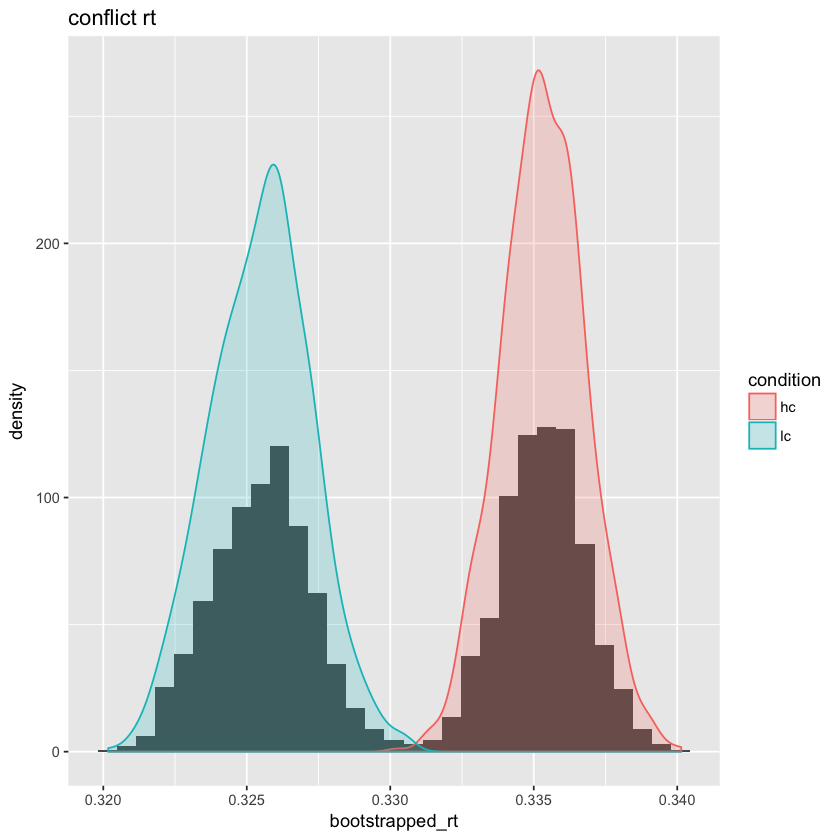

In [52]:
binwidth = diff(range(conflict_rt.boot$bootstrapped_rt))/30
ggplot(conflict_rt.boot, aes(x=bootstrapped_rt)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='conflict rt')

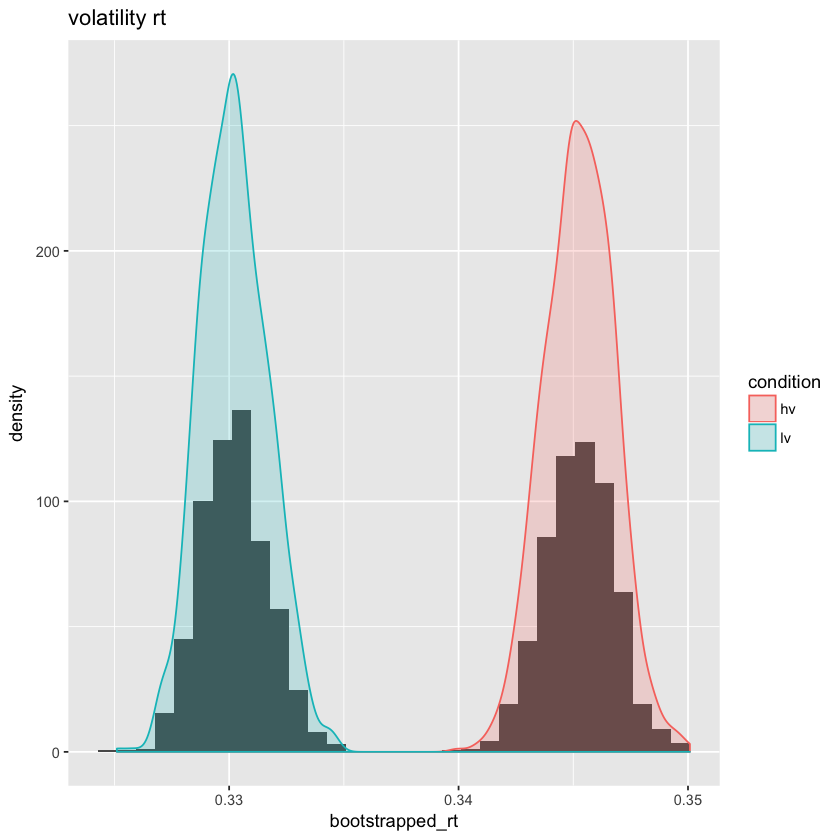

In [53]:
binwidth = diff(range(vol_rt.boot$bootstrapped_rt))/30
ggplot(vol_rt.boot, aes(x=bootstrapped_rt)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='volatility rt')

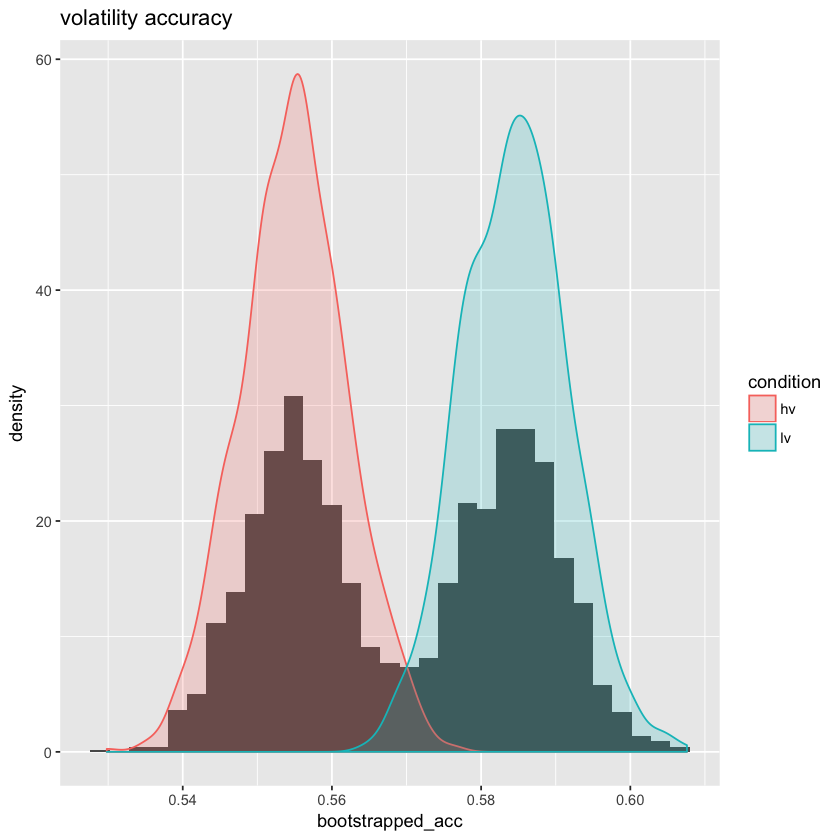

In [54]:
binwidth = diff(range(vol_acc.boot$bootstrapped_acc))/30
ggplot(vol_acc.boot, aes(x=bootstrapped_acc)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='volatility accuracy')

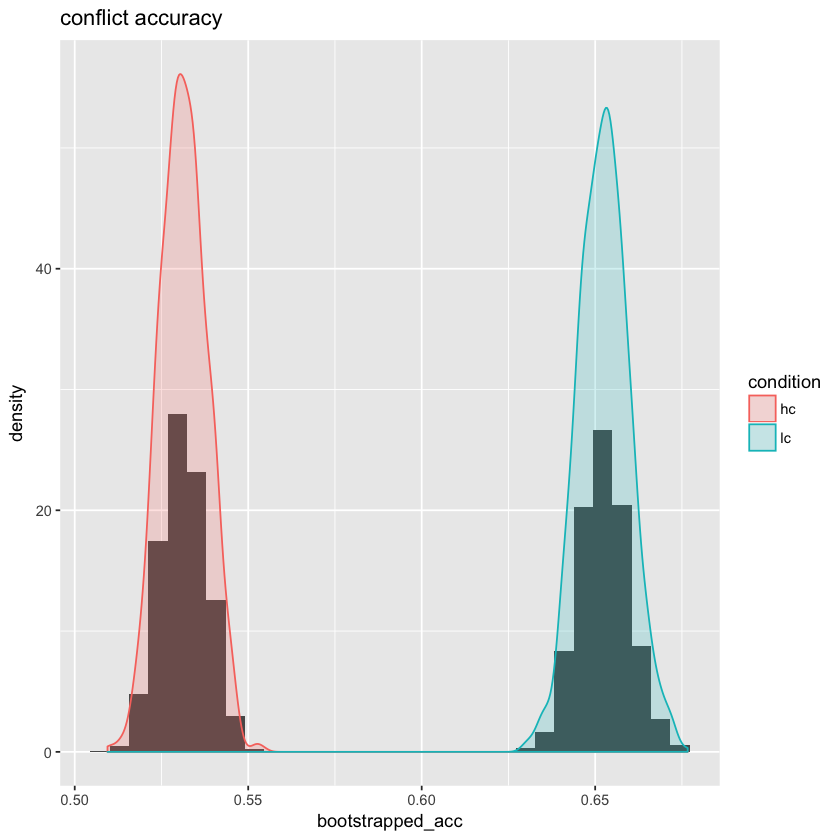

In [55]:
binwidth = diff(range(conflict_acc.boot$bootstrapped_acc))/30
ggplot(conflict_acc.boot, aes(x=bootstrapped_acc)) + 
       geom_histogram(aes(y=..density..),binwidth=binwidth) + geom_density(aes(color=condition, fill=condition), alpha=0.2) + labs(title='conflict accuracy')

## bootstrapping example

In [117]:
library(Lock5Data)
data(CommuteAtlanta)

In [118]:
str(CommuteAtlanta)

'data.frame':	500 obs. of  5 variables:
 $ City    : Factor w/ 1 level "Atlanta": 1 1 1 1 1 1 1 1 1 1 ...
 $ Age     : int  19 55 48 45 48 43 48 41 47 39 ...
 $ Distance: int  10 45 12 4 15 33 15 4 25 1 ...
 $ Time    : int  15 60 45 10 30 60 45 10 25 15 ...
 $ Sex     : Factor w/ 2 levels "F","M": 2 2 2 1 1 2 2 1 2 1 ...


In [119]:
#find sample mean first
(time.mean = with(CommuteAtlanta, mean(Time)))

[1] 29.11

In [120]:
#finding se 
#sample with replacement to form a matrix with one row for each bootstrap sample 
#and one column for each sampled value, matching original n
n_bootstrap_samples = 1000
n_sampled_vals = nrow(CommuteAtlanta)
boot.samples = matrix(sample(CommuteAtlanta$Time, size = n_bootstrap_samples * n_sampled_vals, replace = TRUE),
n_bootstrap_samples, n_sampled_vals)

In [121]:
#now take average of each row of boot samples 
boot.statistics = apply(boot.samples, 1, mean)

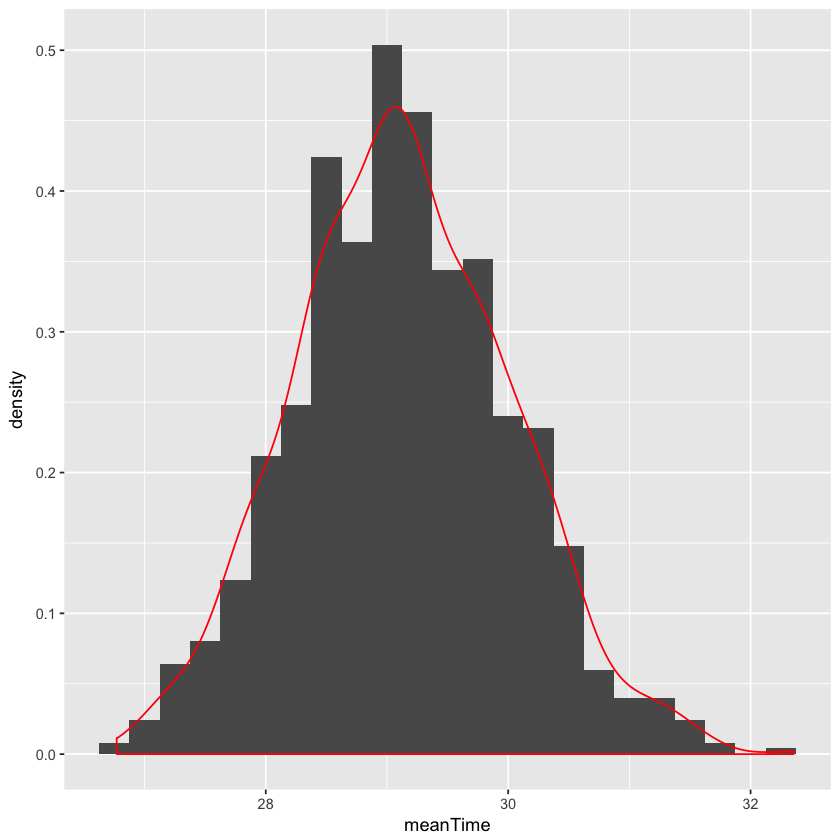

In [122]:
#visualize bootstrapped distribution of means
ggplot(data.frame(meanTime = boot.statistics),aes(x=meanTime)) +
geom_histogram(binwidth=0.25,aes(y=..density..)) +
geom_density(color="red")

In [123]:
#find se of bootstrapped mean (std of dist. of means)
(time.se = sd(boot.statistics))

[1] 0.8889994

In [124]:
#calc. bootstrapped confidence interval 
me = ceiling(10 * 2 * time.se)/10
round(time.mean, 1) + c(-1, 1) * me

[1] 27.3 30.9